In [38]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import corner.corner

from impulse.base import PTSampler

# test model things:
from test_model import make_sin_data, LnLikelihood, LnPrior

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
x, data, omega_real, a_real, phi_real = make_sin_data(1000)

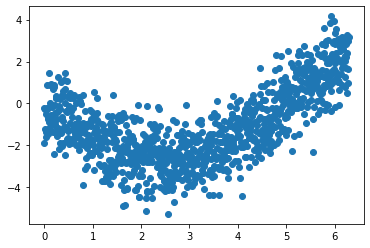

In [40]:
plt.scatter(x, data)

In [41]:
like = LnLikelihood(x, data)
prior = LnPrior([0, 0, 0], [3, 5, np.pi])

In [42]:
x0 = prior.initial_sample()
ndim = len(x0)

In [46]:
ntemps = 8
sampler = PTSampler(like, prior, [x0 for _ in range(ntemps)], tinf=True, num_samples=200_000, ntemps=ntemps, ncores=8, adapt_t0=10, adapt_nu=100, ret_chain=True)

In [47]:
chain = sampler.sample()

100%|██████████| 200/200 [02:43<00:00,  1.23it/s]


In [6]:
ntemps = 8
chain = pt_sample(like, prior, ndim, [x0 for _ in range(ntemps)], tinf=True, ntemps=ntemps, ncores=4, num_samples=200_000, adapt_t0=10, adapt_nu=100, ret_chain=True, temp_dir='./temp_data')

100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


In [48]:
burn = int(0.25 * chain.shape[0])
omega = np.median(chain[burn:, 0, 0])
a = np.median(chain[burn:, 1, 0])
phi = np.median(chain[burn:, 2, 0])

In [49]:
print(omega, omega_real)
print(a, a_real)
print(phi, phi_real)

0.642658568349856 0.6484406157174845
2.764220654246382 2.6993917789983395
3.1142425222945023 3.0950602988304836


In [50]:
with open('./temp_data/temps.txt', 'r') as f:
    temps = np.loadtxt(f)

with open('./temp_data/accept.txt', 'r') as f:
    accept = np.loadtxt(f)

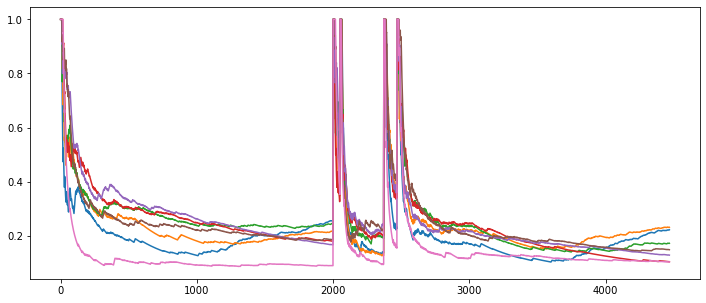

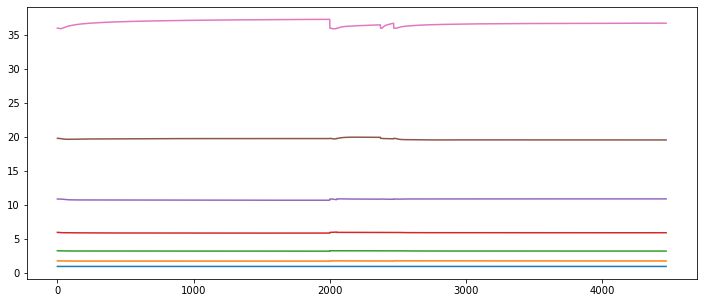

In [51]:
plt.figure(figsize=(12, 5))
for ii in range(ntemps - 1):
    # plt.plot(temps[:, ii])
    plt.plot(accept[:, ii])
plt.show()

plt.figure(figsize=(12, 5))
for ii in range(ntemps - 1):
    plt.plot(temps[:, ii])
    # plt.plot(accept[:, ii])
plt.show()

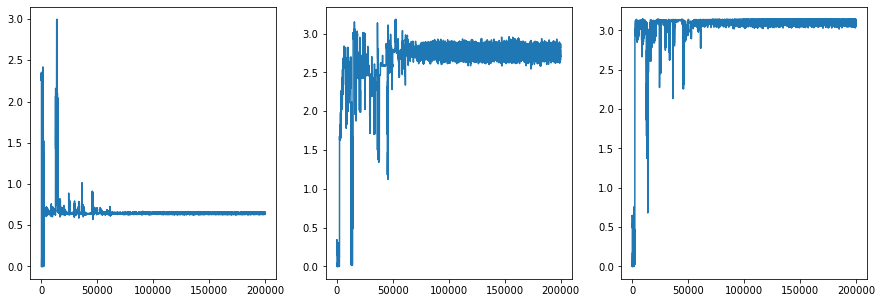

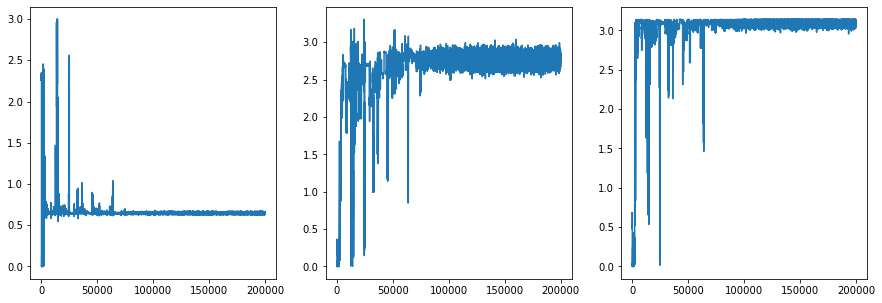

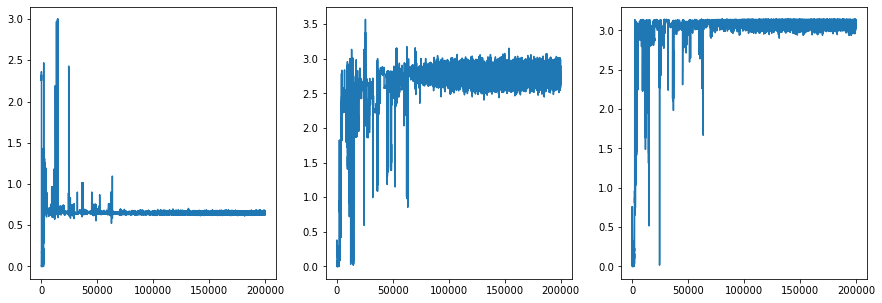

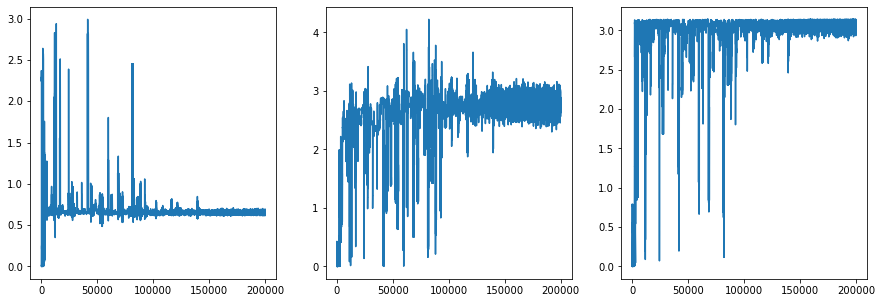

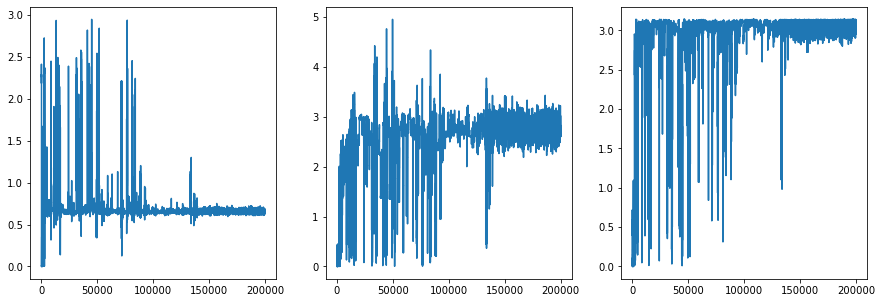

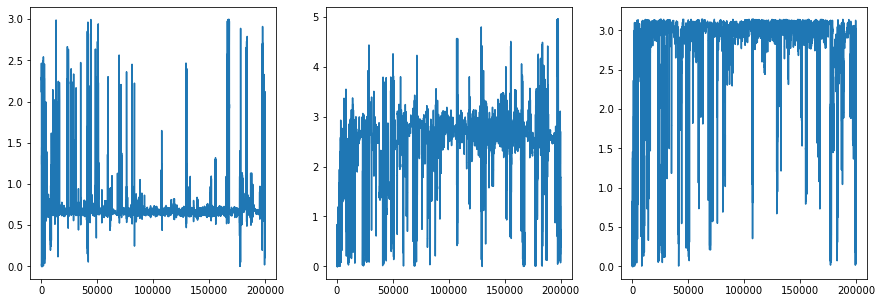

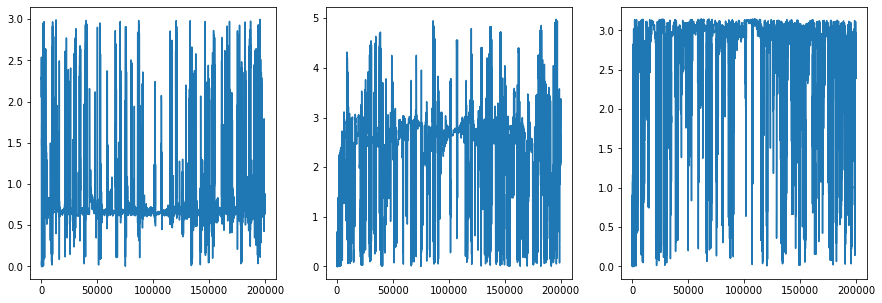

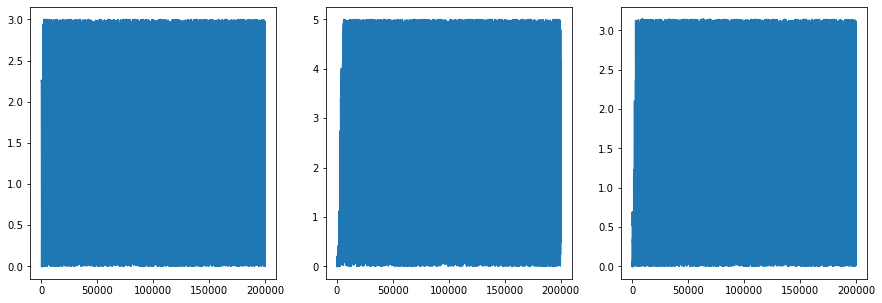

In [52]:
for ii in range(ntemps):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(chain[:, 0, ii])
    ax[1].plot(chain[:, 1, ii])
    ax[2].plot(chain[:, 2, ii])
    plt.show()

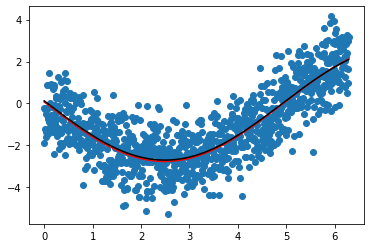

In [53]:
plt.scatter(x, data)
plt.plot(x, a * np.sin(omega * x + phi), color='red')
plt.plot(x, a_real * np.sin(omega_real * x + phi_real), color='black')

In [54]:
print(burn)

50000


In [55]:
print(len(chain))

200000


In [56]:
chain[:, :, 0]

array([[2.25832836, 0.15504882, 0.54065756],
       [2.2610911 , 0.15504882, 0.54065756],
       [2.2610911 , 0.15504882, 0.51961313],
       ...,
       [0.63554096, 2.82226715, 3.11359817],
       [0.63554096, 2.82226715, 3.11359817],
       [0.63554096, 2.82226715, 3.11359817]])

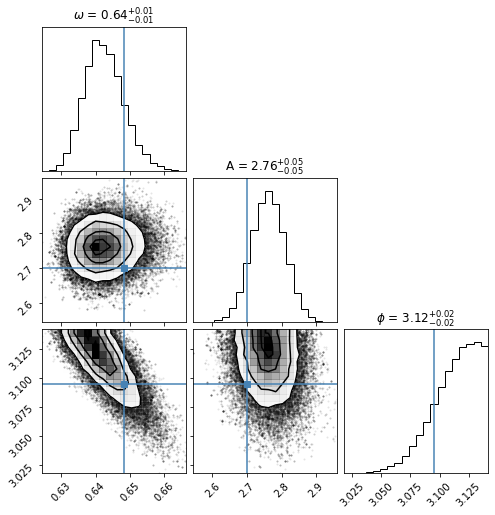

In [57]:
corner.corner(chain[2 * burn:, :, 0], truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True)
plt.show()

In [37]:
print(omega_real, a_real, phi_real)
print(omega, a, phi)

2.6364667368995587 4.777365348705957 0.08941632906674105
2.625500070912346 4.700568476161738 0.14208899427989632
